# Lab 6: Interactive geospatial analysis in a SageMaker AI Studio JupyterLab notebook using a custom SageMaker Distribution Image

This notebook is based on this [notebook](https://github.com/aws-samples/sagemaker-custom-image-for-geospatial-analytics/blob/main/notebooks/01-interactive-geospatial-analyses-custom-image.ipynb) but adapted and extended for a specialized workshop.


__Prerequisites:__ We recommend running this notebook on an `ml.m5.4xlarge`. When launching the JupyterLab Space in SageMaker Studio, make sure to select the custom geospatial image that was created and attached to the SageMaker domain in the previous steps.

In [3]:
# install packages
# !python3 -m pip install --force-reinstall --no-cache -q --no-dependencies -r requirements.txt

In [ ]:
%pip install pandas
%pip install numpy
%pip install geopandas
%pip install shapely
%pip install matplotlib
%pip install plotly_express
%pip install sentinelhub[AWS]
%pip install rasterio
%pip install leafmap
%pip install rioxarray
%pip install earthpy
%pip install folium

In [ ]:
%pip install scooby box

## Import Geospatial Libraries

In [2]:
#geo libraries
import geopandas as gpd
import pandas as pd
import pystac_client
import shapely
from shapely import geometry, wkt
# import leafmap
import rasterio
from rasterio.plot import show
import rioxarray

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

## Define an exemplary Geometry

In [3]:
coords = [[-102.00723310488662,40.596123257503024],[-102.00723310488662,40.58168585757733],[-101.9882214495914,40.58168585757733],[-101.9882214495914,40.596123257503024],[-102.00723310488662,40.596123257503024]]
polgyon = shapely.Polygon(coords)
aoi_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polgyon])

## Visualize the Geometry

In [ ]:
# Map = leafmap.Map(center=[40.596123257503024, -102.00723310488662], zoom=13)
# Map.add_basemap("USGS NAIP Imagery")
# Map.add_gdf(aoi_gdf, layer_name="test", style={"color": "yellow", "fillOpacity": 0.3, "clickable": True,})
# Map

## Search Sentinel-2 Satellite Data for given Geometry

In [15]:
def search_sentinel2_collection(start_date, end_date, aoi_geometry,max_cloud=100):
    """
    Search Sentinel 2 data collection for target_date
    and collect results including meta data in a dictionary.
    This function uses the PySTAC client
    """
    client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    collection = "sentinel-2-l2a"
    
    search = client.search(
        collections=[collection],
        query = {"eo:cloud_cover":{"lt":max_cloud}},
        intersects=aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__, 
        datetime=f"{start_date}/{end_date}"
    )
    
    s2_items = []
    for item in search.items_as_dicts():
        s2_items.append(item)
        
    return s2_items

In [16]:
#search parameters
analysis_start_date = pd.to_datetime("2023-07-01T00:00:00Z").date()
analysis_end_date = pd.to_datetime("2023-07-31T00:00:00Z").date()
aoi_geometry = aoi_gdf.geometry
max_cloud = 5

In [17]:
sentinel2_items = search_sentinel2_collection(
    start_date=analysis_start_date,
    end_date=analysis_end_date,
    aoi_geometry = aoi_geometry,
    max_cloud=max_cloud
)

In [7]:
from IPython.display import JSON
JSON(sentinel2_items)

<IPython.core.display.JSON object>

## Inspect a single Sentinel-2 Item by looking at its Thumbnail 
It's a low-res Preview of the Sentinel-2 Tile

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/KL/2023/7/S2B_14TKL_20230702_0_L2A/thumbnail.jpg


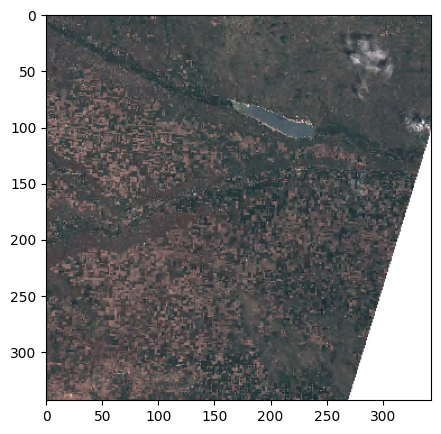

In [8]:
thumbnail_path = sentinel2_items[-1]["assets"]["thumbnail"]["href"]
print(thumbnail_path)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
    src_thumbnail = rasterio.open(thumbnail_path)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
show(src_thumbnail, ax=ax)
plt.show()

## Download selected Sentinel-2 Bands 
Download red, green, blue from S3, clip to Area of Observation (AOI) and visualize.__

In [9]:
def get_rgb_bands(aoi_geometry, sentinel2_item, output_projection="EPSG:4326"):
    """
    Extract red, green, blue (RGB) bands from GeoTiff,
    reproject to desired CRS and collect in array
    """
    aoi_geometry = aoi_geometry.to_crs(output_projection)[0]
    blue = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["blue"]["href"], masked=True)
    green = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["green"]["href"], masked=True)
    red = rioxarray.open_rasterio(sentinel2_items[-1]["assets"]["red"]["href"], masked=True)

    bands = []
    for band in [red, green, blue]:
        kwargs = {"nodata": np.nan}
        band_reprojected = band.rio.reproject(output_projection, **kwargs)
        bands.append(band_reprojected.rio.clip(geometries=[geometry.mapping(aoi_geometry)]))
    return bands

def normalize_rgb_bands(rgb_bands):
    """
    Re-scale/normalize rgb bands to range [0,255]
    """
    bands = []
    for band in rgb_bands:
        img_arr = band.to_numpy()
        normalized = img_arr / np.amax(img_arr)
        normalized = normalized * 255
        bands.append(normalized.astype(np.uint8)[0])
    return np.array(bands)

In [10]:
bands = get_rgb_bands(aoi_geometry=aoi_geometry, sentinel2_item=sentinel2_items[-1], output_projection="EPSG:3857")
bands_norm = normalize_rgb_bands(bands)

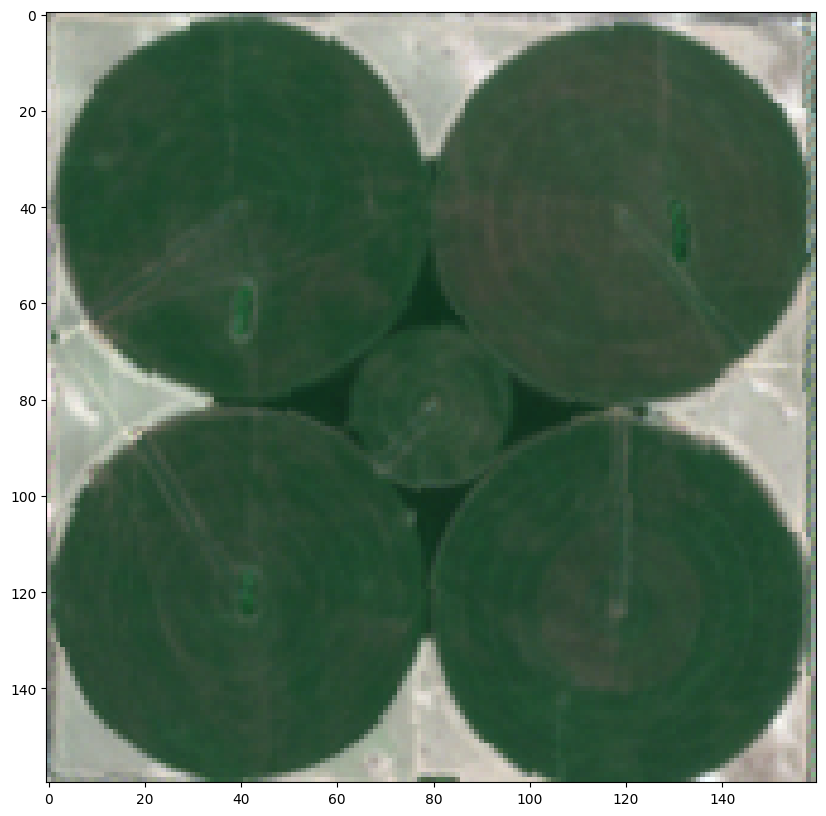

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(bands_norm.transpose(1, 2, 0))
plt.show()